# Comparison of xapres with matlab apres code
ApRES data is traditionally processed with code written in matlab supplied by bas (fmcw_plot, etc., https://github.com/ldeo-glaciology/phase-sensitive-radar-processing/tree/main/code/ApRES_Utils_Nicholls_250221). 

Here we compare the results of running xpares and the results of running scripts from this collection of matlab code. 

There are some very small differences in the profiles. Three of which motivate changes to the xpares code. The remaining differences are due to different constants being used. It is not a big issue. 
 

In [1]:
%load_ext autoreload
%autoreload 2 
import sys
sys.path.append("../../../xapres/")
import xapres as xa
import matplotlib.pyplot as plt
import numpy as np

In [208]:

# load the chirps, perform an fft, and put them all in an xarray
directory = '../../data/sample/thwaites/'
p_data = xa.load.generate_xarray(directory=directory, addProfileToDs_kwargs={'max_range': 2500})
p_chirps = p_data['chirp']

100%|██████████| 1/1 [00:00<00:00,  2.02it/s]


## Load output of matlab code
Output created using this version of the fmcw code: https://github.com/ldeo-glaciology/phase-sensitive-radar-processing/tree/main/code/ApRES_Utils_Nicholls_250221
and these commands
```
vdat = fmcw_load('../data/sample/thwaites/DATA2023-02-12-0437.DAT'); %defaults to just the first burst
[rc,~,spec_cor,spec] = fmcw_range(vdat,2,2500,@blackman);
save('../data/sample/thwaites/DATA2023-02-12-0437_p4.mat')
```

It creates three variables:

- vdat, which contians all the header info and the chirp data
- rc, which is the range 
- spec_cor, which is the data after the fft with a phase correction (phiref)
- spec, which is the data after the fft without the correction

There are 100 chirps in these data. 

In [184]:
# import mat file from the data directory
import scipy.io as sio
m_data = sio.loadmat('../../data/sample/thwaites/DATA2023-02-12-0437_p2.mat')

In [185]:
m_range = m_data['rc']
m_profiles = m_data['spec_cor']
m_profiles_unccorrected = m_data['spec']

vdat = m_data['vdat']

In [24]:
vdat.dtype

dtype([('Code', 'O'), ('Nsamples', 'O'), ('SubBurstsInBurst', 'O'), ('Average', 'O'), ('NAttenuators', 'O'), ('TxAnt', 'O'), ('RxAnt', 'O'), ('ChirpsInBurst', 'O'), ('Attenuator_1', 'O'), ('Attenuator_2', 'O'), ('TimeStamp', 'O'), ('Temperature_1', 'O'), ('Temperature_2', 'O'), ('BatteryVoltage', 'O'), ('v', 'O'), ('Startind', 'O'), ('Endind', 'O'), ('Burst', 'O'), ('FileFormat', 'O'), ('filename', 'O'), ('SamplesPerChirp', 'O'), ('fs', 'O'), ('f0', 'O'), ('K', 'O'), ('processing', 'O'), ('f1', 'O'), ('T', 'O'), ('B', 'O'), ('fc', 'O'), ('dt', 'O'), ('er', 'O'), ('ci', 'O'), ('lambdac', 'O'), ('vif', 'O'), ('chirpNum', 'O'), ('chirpAtt', 'O'), ('chirpTime', 'O'), ('t', 'O'), ('f', 'O')])

In [25]:
m_chirps = vdat[0,0]['vif']
m_chirp = m_chirps[0,]

## Compare the chirps

In [26]:
p_chirp = p_chirps.isel(time=0, chirp_num=0).values.squeeze()

In [27]:
p_chirp.shape, m_chirp.shape

((40001,), (40000,))

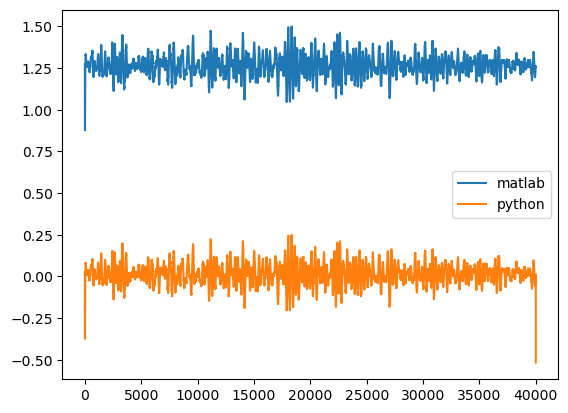

In [28]:
plt.plot(m_chirp, label='matlab')
plt.plot(p_chirp, label='python')
plt.legend()


(0.0, 1000.0)

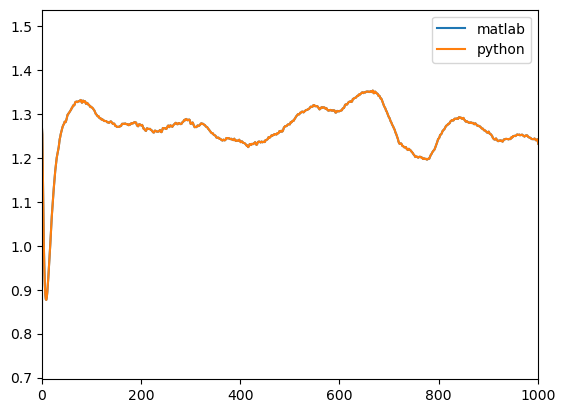

In [29]:
plt.plot(m_chirp, label='matlab')
plt.plot(p_chirp+1.25, label='python')
plt.legend()
plt.xlim(0,1000)


In [30]:
m_chirp == p_chirp[:len(m_chirp)] + 1.25


array([ True,  True,  True, ...,  True,  True,  True])

## Summary of chirp comparison
There are two differences:
1. The matlab chirps are one element shorter than the python ones. 

2. The python chirps are uniformly 2.5 less than the matlab ones. 
This is because in the python loading code there is a `-2.5` at the end of `Burst.v = (np.frombuffer(inbuff, dtype=np.uint16))/2**16*2.5-1.25` and there is no equivelent in the matlab code. The same factor of (1/2**16)*2.5 is used but not the -1.25.

## Solutions
1. The difference in length is not a problem, but we can trim the chirps by on element before we compute profiles to make them more like the matlab profiles. 
2. The `-2.5` is odd, but if we demean the data before the fft, then it doenst make any difference to the result. demeaning is the default in the matlab code and we should (see more below) make this the default in the python code. 


## Compare the profiles

In [209]:
p_profile = p_data['profile'].isel(time=0, chirp_num=0).values.squeeze()
p_profile.shape
p_range = p_data.profile_range.values.squeeze()
p_range.shape

(11889,)

In [210]:
m_profile = m_profiles[0,]
m_profile.shape
m_profile_unccorrected  = m_profiles_unccorrected[0,]
m_range = m_range.squeeze()
m_range.shape

(11889,)

/Users/jkingslake/miniconda3/envs/full_py_env/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/jkingslake/miniconda3/envs/full_py_env/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


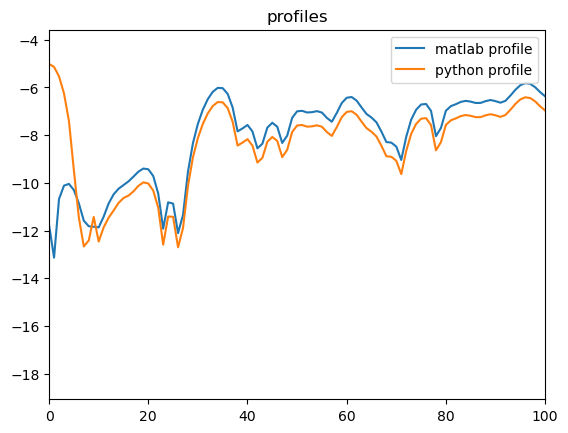

In [33]:
plt.plot(np.log(m_profile), label = 'matlab profile')

plt.plot(np.log(p_profile), label = 'python profile')
plt.xlim(0, 100)
plt.title('profiles')
plt.legend()


There is a pervasive offset in the plot above, which is a log plot, meaning that there is uniform scaling between the two. This is due to a scaling to account for the windowing function that the matlab code does but the python code does not do. 


(0.0, 100.0)

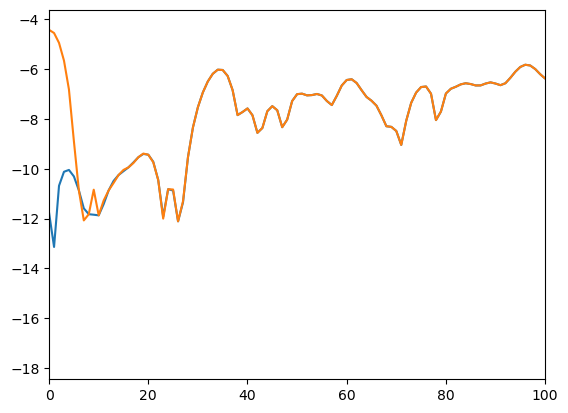

In [34]:
plt.plot(np.log(m_profile), label = 'matlab profile')

rdei = lambda x: int(np.floor(x/2) * 2)
Nt = rdei(p_data.chirp_time.size) 

temp = p_data.chirp.computeProfile().isel(time=0, chirp_num=0, profile_range = slice(0,len(m_profile))).values.squeeze() / np.sqrt(np.mean((np.blackman(Nt))**2))
plt.plot(np.log(temp))
plt.xlim(0, 100)

This improves things a lot, but there are differences at low frequencies. 

First, the matlab code demeans the chirp by default before computing the fft. This is not done in the python code.



/Users/jkingslake/miniconda3/envs/full_py_env/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/jkingslake/miniconda3/envs/full_py_env/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(0.0, 100.0)

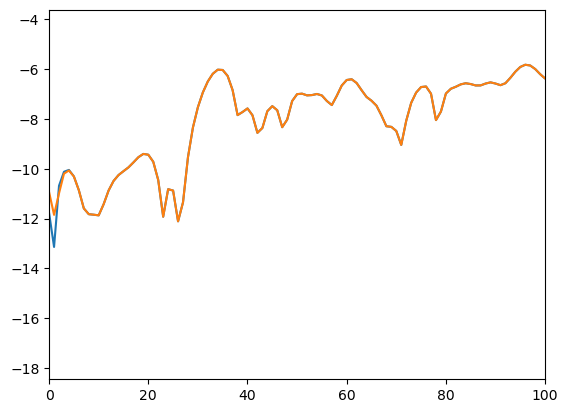

In [35]:
plt.plot(np.log(m_profile), label = 'matlab profile')

temp = p_data.chirp.computeProfile(demean = True).isel(time=0, chirp_num=0, profile_range = slice(0,len(m_profile))).values.squeeze() / np.sqrt(np.mean((np.blackman(Nt))**2))
plt.plot(np.log(temp))
plt.xlim(0, 100)

This improves the match at low frequencies, but a slight mismatch. This is due to the length of the chirps being one element different:


/Users/jkingslake/miniconda3/envs/full_py_env/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/jkingslake/miniconda3/envs/full_py_env/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(0.0, 100.0)

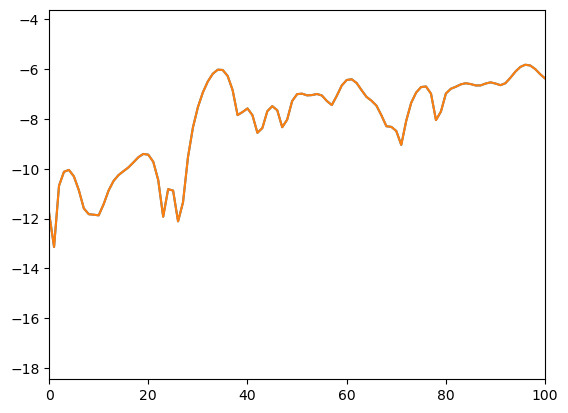

In [123]:
plt.plot(np.log(m_profile), label = 'matlab profile')

temp = p_data.chirp.isel(chirp_time = slice(0,-1)).computeProfile(demean = True).isel(time=0, chirp_num=0, profile_range = slice(0,len(m_profile))).values.squeeze() / np.sqrt(np.mean((np.blackman(Nt))**2))
plt.plot(np.log(temp))
plt.xlim(0, 100)

This improves the match a lot and makes the magnitdues of the complex profiles match exactly. 

In [124]:
assert np.allclose(abs(temp), abs(m_profile))

## Phase comparison
However, the phase of the complex profiles is not the same. 

In [125]:
np.allclose((temp),( m_profile))

False

/Users/jkingslake/miniconda3/envs/full_py_env/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/jkingslake/miniconda3/envs/full_py_env/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


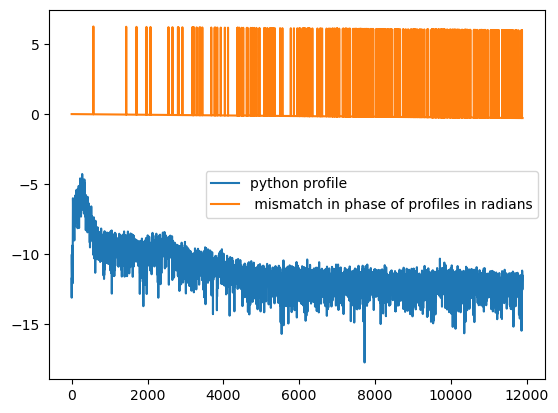

In [144]:
plt.plot(np.log(temp), label ='python profile')
plt.plot((np.angle(temp)-np.angle(m_profile)), label = ' mismatch in phase of profiles in radians')
plt.legend()

The ranges are also not exactly the same



In [135]:
m_range, p_data.profile_range.values

(array([0.00000000e+00, 2.10287957e-01, 4.20575913e-01, ...,
        2.49948265e+03, 2.49969294e+03, 2.49990323e+03]),
 array([0.00000000e+00, 2.10289558e-01, 4.20579116e-01, ...,
        2.49950168e+03, 2.49971197e+03, 2.49992226e+03]))

Text(0.5, 1.0, 'mismatch in range values')

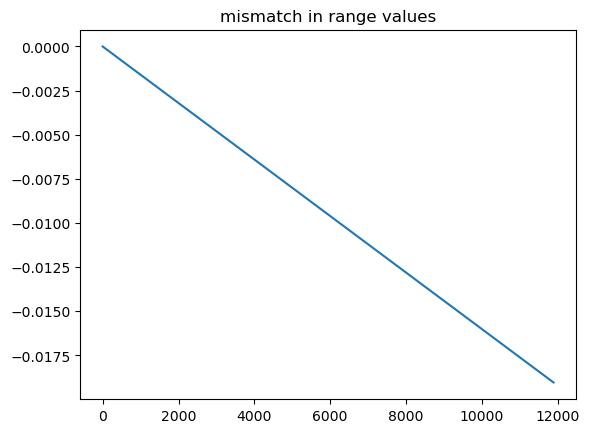

In [145]:
plt.plot(m_range- p_data.profile_range.values)
plt.title('mismatch in range values')

The problem is in the constants that are using when computing the reference array (`phiref`), which causes the difference in the phase of the profiles, and in the computation of course range, which happens in `freq2range` in the oytoh code and is simply `n*ci/(2*B*p)` in the matlab code. 

The values of `B`, `K` and `fc` are slightly different in each case. 

In the python code, `K` is computed as `Burst.Header["K"] = Burst.Header["FreqStepUp"] / Burst.Header["TStepUp"]`, where `FreqStepUp`  and `TStepUp` come from the burst header. This works out to be:

In [98]:
p_data.attrs['constants']['K']

200000000.0

`B` is computed with `Burst.Header["B"] = (Burst.Header["StopFreq"] - Burst.Header["StartFreq"])` and works out to be

In [101]:
p_data.attrs['constants']['B']

200000000

`fc` is computed qith `Burst.Header["CentreFreq"] = (Burst.Header["StartFreq"] + Burst.Header["StopFreq"])/2`

In [102]:
p_data.attrs['constants']['f_c']

300000000.0

In the matlab code `K` is computed as `H.K = 2*pi*(H.rampUpStep/H.tstepUp)` and `B` and `fc` are computed from `K`. H.rampUpStep is extracted from a hex string after Reg0C= in burster header. The python code doesnt do this, so I am not sure the reason for the 

In [103]:
vdat[0][0]['B'][0][0], vdat[0][0]['K'][0][0]/2/np.pi, vdat[0][0]['fc'][0][0]

(200001522.898674, 200001522.898674, 300000761.4027709)

In [111]:
print(f" there's a {(vdat[0][0]['K'][0][0]/2/np.pi - p_data.attrs['constants']['K'])/p_data.attrs['constants']['K'] * 100}% difference in K")

 there's a 0.0007614493370056152% difference in K


`H.rampUpStep` is used to compute `K`. It is extracted from a hex string after 'Reg0C=' in burst header (in fmcw_ParametersRMB2.m). The python code doesnt do this, so I am not sure the reason for the difference. 

You can define the constans to use in `computeProfile`. This shows that this difference in the constants accounts for the remaining difference in the profiles:

/Users/jkingslake/miniconda3/envs/full_py_env/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/jkingslake/miniconda3/envs/full_py_env/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


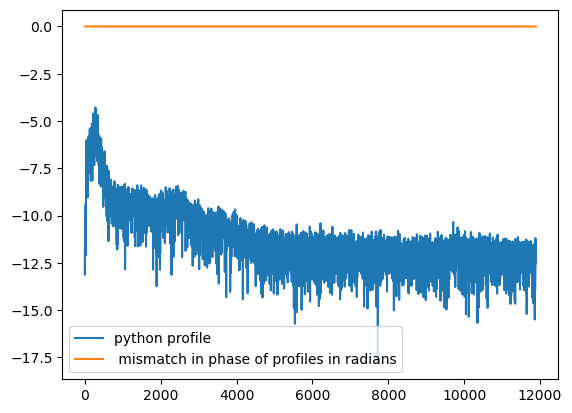

In [147]:
constants = {}
constants['T'] = 1               # chirp duration [s]
constants['f_1'] = 200e6         # starting frequency [Hz]
constants['f_2'] = 400e6         # ending frequency [Hz]
constants['B'] = vdat[0][0]['B'][0][0]         # bandwidth [Hz]
constants['K'] = vdat[0][0]['K'][0][0]/2/np.pi            # rate of chnge of frequency [Hz/s]
constants['c'] = 300000000.0     # speed of light in a vacuum [m/s]
constants['ep'] = 3.18           # permittivity of ice
constants['f_c'] = vdat[0][0]['fc'][0][0]# center frequency [Hz]
constants['dt'] = 1/40000        # time step [s]

temp_new_constants = p_data.chirp.isel(chirp_time = slice(0,-1)).computeProfile(demean = True, constants=constants).isel(time=0, chirp_num=0, profile_range = slice(0,len(m_profile))).values.squeeze()/ np.sqrt(np.mean((np.blackman(Nt))**2)) 
plt.plot(np.log(temp_new_constants), label ='python profile')
plt.plot((np.angle(temp_new_constants)-np.angle(m_profile)), label = ' mismatch in phase of profiles in radians')
plt.legend()

Double check that all 100 profiles in this chirp match:

In [172]:
temp_new_constants.shape

(100, 11889)

In [189]:
temp_new_constants = p_data.chirp.isel(chirp_time = slice(0,-1)).computeProfile(demean = True, constants=constants).isel(time=0, profile_range = slice(0,len(m_profile))).values.squeeze()/ np.sqrt(np.mean((np.blackman(Nt))**2)) 


np.allclose(m_profiles, temp_new_constants)

True

## Summary of profile(and range) comparison
There are several differences. 
1. There is uniform offset in the plot above, which is a log plot, meaning that there is uniform scaling between the two. This is due to a scaling to account for the windowing function that the matlab code does but the python code does not do.  
2. The matlab code demeans the chirp by default before computing the fft. This is not done in the python code. This causes the lowest frequencies to be different. 
3. The chirps are one element different in length and htis carries through to the profile calculation and slightly affects the low frequencies.
4. The constants used in the two codes are different. This also affects the range very slightly. 
 
When all these are corrected for the profiles all match. 

### Solutions:
1. Add the window scaling to computeProfiles
2. Make demean=True the default in computeProfiles
3. In utils we already trim the chirps to get an even number of samples. We just need to move where we do this to before we compute the mean. 

For 3. and 4. I dont think any changes are needed. As long as things are done consistently, any differences i the results resulting from these differences are going to be very small. 

The cell below should give True AFTER these changes have been implemented in utils.py



In [22]:
temp_new_constants = p_data.chirp.isel().computeProfile(constants=constants, max_range = 2500).isel(time=0).values.squeeze() 
np.allclose(m_profiles, temp_new_constants)

True